# Spotify Music Recommendation System: 

In [369]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [372]:
client_id = #Enter Yours
client_secret = #Enter Yours
scope = 'user-library-read'
user = #Your User Name

In [378]:
token = util.prompt_for_user_token(user,scope,client_id=client_id,
                                   client_secret=client_secret,
                                  redirect_uri='http://localhost:8123/callback/')

In [374]:
sp = spotipy.Spotify(auth=token)

___For Saved Tracks:___

In [375]:
saved_tracks = sp.current_user_saved_tracks(limit = 20)

___For Playlist Discovery:___

In [376]:
playlist_discovery = {}
playlist_cover_art = {}
for i in sp.current_user_playlists()['items']:
    playlist_discovery[i['name']] = i['uri'].split(':')[2]
    playlist_cover_art[i['uri'].split(':')[2]] = i['images'][0]['url']

In [377]:
playlist_discovery

{'Holy_Grail_of_Music': '11CzOAmUvRe2by0X5KQ1Uz',
 'God Tier Hip Hop': '0ul7gtT2xQ2VCgjzNt8msG'}

___Importing our spotify features dataset(found on kaggle):___

In [328]:
spotify_data_read = pd.read_csv('../Rajit/SpotifyFeatures.csv')
spotify_data = spotify_data_read.drop_duplicates(subset=['track_name'],keep = 'first')
print(spotify_data.shape)

(148615, 18)


___Making a saved songs DF:___

In [365]:
def generating_saved_songs(saved_tracks,spotify_data):
    
    saved_songs = pd.DataFrame()
    
    for i, j in enumerate(saved_tracks['items']):
        saved_songs.loc[i,'track_name'] = j['track']['name']
        saved_songs.loc[i,'artist_name'] = j['track']['artists'][0]['name']
        saved_songs.loc[i,'track_id'] = j['track']['id']
        saved_songs.loc[i,'release_date'] = j['track']['album']['release_date']
        saved_songs.loc[i,'date_added'] = j['added_at']
        saved_songs.loc[i,'url'] = j['track']['album']['images'][1]['url']
    
    saved_songs['date_added'] = pd.to_datetime(saved_songs['date_added']) 
    saved_songs['release_date'] = pd.to_datetime(saved_songs['release_date']) 
        
    saved_songs = pd.DataFrame(saved_songs[saved_songs['track_id'].isin(saved_songs['track_id'].values)
                                          ]).sort_values('release_date', ascending = False)
    return saved_songs

In [366]:
saved_songs = generating_saved_songs(saved_tracks,spotify_data)
saved_songs.head()

track_name  artist_name                track_id release_date  \
0         Ziploc       88GLAM  02Ak5xEjojFSbhap7gvIDM   2022-03-18   
1           Pool  Still Woozy  1Z82ecXtEeTGpQZYL4URxN   2022-03-17   
3       Iced Tea  Joyce Wrice  6kmXHLDDK7RQXTjHooTCzH   2022-03-16   
4   It's A Killa       FISHER  2cAYjs1WvosMFadzTDmmzD   2022-03-11   
13    Killing Me  Omar Apollo  1vghSeMBb7AIMT3JaMrlHO   2022-03-11   

                  date_added  \
0  2022-03-19 19:58:03+00:00   
1  2022-03-19 19:57:05+00:00   
3  2022-03-17 06:51:46+00:00   
4  2022-03-15 17:19:50+00:00   
13 2022-03-11 16:15:31+00:00   

                                                  url  
0   https://i.scdn.co/image/ab67616d00001e022a40b7...  
1   https://i.scdn.co/image/ab67616d00001e02fbe628...  
3   https://i.scdn.co/image/ab67616d00001e02c5fc4f...  
4   https://i.scdn.co/image/ab67616d00001e029b84d8...  
13  https://i.scdn.co/image/ab67616d00001e020c459a...

___Creating a data frame for our playlist:___

In [331]:
def generating_playlist(playlist_name,playlist_discovery,spotify_data):
    playlist = pd.DataFrame()
    
    for i, j in enumerate(sp.playlist(playlist_discovery[playlist_name])['tracks']['items']):
        playlist.loc[i, 'track_name'] = j['track']['name']
        playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
        playlist.loc[i, 'track_id'] = j['track']['id']
        playlist.loc[i ,'release_date'] = j['track']['album']['release_date']
        playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
        playlist.loc[i, 'date_added'] = j['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added']) 
    playlist['release_date'] = pd.to_datetime(playlist['release_date']) 
    
    playlist = pd.DataFrame(playlist[playlist['track_id'].isin(spotify_data['track_id'].values)]).sort_values('release_date',
                                                                                                         ascending = False)
    return playlist

In [332]:
playlist = generating_playlist('Holy_Grail_of_Music',playlist_discovery,spotify_data)

In [333]:
playlist.head()

track_name                  artist  \
31              Superpowers (with GoldLink)               Col3trane   
87                              Foot Fungus  Ski Mask The Slump God   
84          E. Coli (feat. Earl Sweatshirt)           The Alchemist   
50                                  151 Rum                     JID   
56  Borrowed Love (feat. Swae Lee & WizKid)            Metro Boomin   

                  track_id release_date  \
31  1iZjxPc5GJhEBl6CZOZXTw   2019-05-31   
87  3EikYy40GMSp8l5mDV6IQo   2018-11-30   
84  3GXSywNvYLAVUCtjMHkKDh   2018-11-30   
50  22WV03i2lBbwNVCE1g671p   2018-11-26   
56  0NA5xAtDra50d0Lfs2uvoh   2018-11-06   

                                                  url  \
31  https://i.scdn.co/image/ab67616d00001e0216e310...   
87  https://i.scdn.co/image/ab67616d00001e02e62c85...   
84  https://i.scdn.co/image/ab67616d00001e02795e70...   
50  https://i.scdn.co/image/ab67616d00001e02f5991f...   
56  https://i.scdn.co/image/ab67616d00001e022887f8...   

                  date_added  
31 2022-03-22 18:40:02+00:00  
87 2022-03-22 18:40:02+00:00  
84 2022-03-22 18:40:02+00:00  
50 2022-03-22 18:40:02+00:00  
56 2022-03-22 18:40:02+00:00

___Making a csv file of our generated playlists:___

In [334]:
playlist.to_csv('playlist.csv')
saved_songs.to_csv('saved_songs.csv')

___Function to Visualize the Cover Art of the playlist:___

In [356]:
def generating_cover_art(playlist_df):
    temp = playlist_df['url'].values
    plt.figure(figsize=(15,int(0.8 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s='' 
        plt.xlabel(s.join(playlist_df['track_name'].values[i].split(' ')[:4]), fontsize = 14, fontweight='bold')
        plt.tight_layout(h_pad=0.8, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

___Extracting Features to generate recommendations:___

In [336]:
track_features = spotify_data 
#getting OHE value of genres
genre_OHE = pd.get_dummies(track_features.genre)
#getting OHE values of music keys
key_OHE = pd.get_dummies(track_features.key)

___Scaling the feature values for better results:___ 

In [337]:
scaled_features = MinMaxScaler().fit_transform([track_features['acousticness'].values,
                                                track_features['danceability'].values,
                                                track_features['duration_ms'].values,
                                                track_features['energy'].values,
                                                track_features['instrumentalness'].values,
                                                track_features['liveness'].values,
                                                track_features['loudness'].values,
                                                track_features['speechiness'].values,
                                                track_features['tempo'].values,
                                                track_features['valence'].values])

___Dropping Columns we dont need for our feature dataframe:___

In [338]:
track_features = track_features.drop('genre',axis = 1)
track_features = track_features.drop('track_name',axis = 1)
track_features = track_features.drop('artist_name', axis = 1)
track_features = track_features.drop('popularity',axis = 1)
track_features = track_features.drop('key', axis = 1)
track_features = track_features.drop('mode', axis = 1)
track_features = track_features.drop('time_signature', axis = 1)

___Making the Dataset that contains the features of the track list of the spotify songs dataset:___

In [339]:
track_features = track_features.join(genre_OHE)
track_features = track_features.join(key_OHE)

In [340]:
track_features.head()

track_id  acousticness  danceability  duration_ms  energy  \
0  0BRjO6ga9RKCKjfDqeFgWV         0.611         0.389        99373   0.910   
1  0BjC1NfoEOOusryehmNudP         0.246         0.590       137373   0.737   
2  0CoSDzoNIKCRs124s9uTVy         0.952         0.663       170267   0.131   
3  0Gc6TVm52BwZD07Ki6tIvf         0.703         0.240       152427   0.326   
4  0IuslXpMROHdEPvSl1fTQK         0.950         0.331        82625   0.225   

   instrumentalness  liveness  loudness  speechiness    tempo  ...  B  C  C#  \
0             0.000    0.3460    -1.828       0.0525  166.969  ...  0  0   1   
1             0.000    0.1510    -5.559       0.0868  174.003  ...  0  0   0   
2             0.000    0.1030   -13.879       0.0362   99.488  ...  0  1   0   
3             0.000    0.0985   -12.178       0.0395  171.758  ...  0  0   1   
4             0.123    0.2020   -21.150       0.0456  140.576  ...  0  0   0   

   D  D#  E  F  F#  G  G#  
0  0   0  0  0   0  0   0  
1  0   0  0  0   1  0   0  
2  0   0  0  0   0  0   0  
3  0   0  0  0   0  0   0  
4  0   0  0  1   0  0   0  

[5 rows x 50 columns]

In [341]:
def generating_playlist_vector(features_df,playlist,weight_factor):
    #making playlist vector for songs present in the spotipy dataset
    features_df_playlist = features_df[features_df['track_id'].isin(playlist['track_id'].values)]
    features_df_playlist = features_df_playlist.merge(playlist[['track_id','release_date']],
                                                            on = 'track_id', how ='inner').sort_values('release_date',
                                                                                                       ascending = False)
    #features of songs not in our playlist
    features_df_nonplaylist = features_df[~features_df['track_id'].isin(playlist['track_id'].values)]

    most_recent_release = features_df_playlist.iloc[0,-1]

    for col,row in features_df_playlist.iterrows():
        features_df_playlist.loc[col,'recent_release'] = int((most_recent_release.to_pydatetime() - row.iloc[-1].to_pydatetime()).days)

    features_df_playlist['weight'] = features_df_playlist['recent_release'].apply(lambda x: weight_factor ** (-x))
    features_df_weighted = features_df_playlist.copy()
    features_df_weighted.update(features_df_weighted.iloc[:,:-3].mul(features_df_weighted.weight.astype(int),0))
    features_df_weighted_final = features_df_weighted.iloc[:, :-3]

    return features_df_weighted_final.sum(axis = 0), features_df_nonplaylist

In [342]:
playlist_vector,nonplaylist_songs = generating_playlist_vector(track_features,playlist,1.5)
saved_songs_vector, nonsaved_songs = generating_playlist_vector(track_features,saved_songs,1.5)

In [343]:
print(playlist_vector.shape)
print(nonplaylist_songs.shape)
print(saved_songs_vector.shape)
print(nonsaved_songs.shape)

(50,)
(148566, 50)
(50,)
(148612, 50)


___Generating Recommendations:___ 

In [344]:
def generating_recommendations(spotify_data, playlist_vector, nonplaylist_songs):

    not_on_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_songs['track_id'].values)]
    not_on_playlist['sim'] = cosine_similarity(nonplaylist_songs.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]
    not_on_playlist_top10 = not_on_playlist.sort_values('sim',ascending = False).head(10)
    not_on_playlist_top10['url'] = not_on_playlist_top10['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return  not_on_playlist_top10

In [345]:
top10_for_playlist_input = generating_recommendations(spotify_data,playlist_vector,nonplaylist_songs)
top10_for_savedsongs_input = generating_recommendations(spotify_data,saved_songs_vector,nonsaved_songs)

In [346]:
top10_for_playlist_input

genre          artist_name                   track_name  \
9688    Alternative           Kiana Ledé               Get In The Way   
3336    Alternative             The 1975                     Menswear   
3495    Alternative              Raveena                        Honey   
12197   Alternative            Destroyer  It's Gonna Take an Airplane   
62502          Folk               Ásgeir               King and Cross   
174409       Comedy          Doug Benson           Marijuana vs. Meth   
83867           R&B             DeJ Loaf                    Go DeJ Go   
40675          Folk  The Doobie Brothers          Listen to the Music   
10452   Alternative         Majid Jordan            What You Do to Me   
227980         Soul          Marvin Gaye  I Want You - Single Version   

                      track_id  popularity  acousticness  danceability  \
9688    53wnHRbMkUJ023eRQzATs9          49       0.67200         0.596   
3336    1v07ywlVYd02pOCnXRBDNA          51       0.51300         0.713   
3495    6ohzjop0VYBRZ12ichlwg5          55       0.43200         0.805   
12197   2fvi6I5iNK69YNhYJqwTF1          48       0.35400         0.611   
62502   6ebPr3K76DCY8ge2uWZP8G          43       0.27700         0.705   
174409  2sh4c59hHdQvOvgFBJwMne          14       0.81200         0.557   
83867   0BAGrgjRV1tjOU46sQtA6w          45       0.00336         0.872   
40675   7Ar4G7Ci11gpt6sfH9Cgz5          75       0.22100         0.645   
10452   7DG6lGfy2W2bMstHlXTMSu          47       0.03290         0.728   
227980  5OFD3jSOLc9Ked6ZuTO839          50       0.51600         0.525   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
9688         167893   0.470          0.000000  C#    0.1020    -8.855  Major   
3336         206738   0.536          0.024600  C#    0.0870   -10.108  Major   
3495         272331   0.270          0.003590  C#    0.0785   -14.967  Major   
12197        221427   0.384          0.000027   B    0.1030   -12.721  Minor   
62502        212679   0.473          0.003700  C#    0.1070   -11.151  Minor   
174409       272623   0.533          0.000000  C#    0.3180   -15.625  Major   
83867        199041   0.390          0.000029  C#    0.1110   -10.460  Major   
40675        227267   0.598          0.000004  C#    0.0721   -13.180  Minor   
10452        216280   0.337          0.000000   D    0.0552   -12.363  Minor   
227980       216520   0.797          0.000005  C#    0.1520   -11.168  Minor   

        speechiness    tempo time_signature  valence  sim  \
9688         0.5370   77.814            4/4   0.7330  1.0   
3336         0.0630   97.012            4/4   0.1580  1.0   
3495         0.0514  129.000            4/4   0.3690  1.0   
12197        0.0292  103.005            4/4   0.5510  1.0   
62502        0.0280  100.005            3/4   0.4250  1.0   
174409       0.9380  126.806            4/4   0.2140  1.0   
83867        0.1880   93.008            4/4   0.0812  1.0   
40675        0.0335  105.929            4/4   0.9130  1.0   
10452        0.1690  101.726            4/4   0.2100  1.0   
227980       0.0656  100.518            4/4   0.7910  1.0   

                                                      url  
9688    https://i.scdn.co/image/ab67616d00001e026a8933...  
3336    https://i.scdn.co/image/ab67616d00001e02ebcc3e...  
3495    https://i.scdn.co/image/ab67616d00001e0239395a...  
12197   https://i.scdn.co/image/ab67616d00001e02bc3b8b...  
62502   https://i.scdn.co/image/ab67616d00001e0250b606...  
174409  https://i.scdn.co/image/ab67616d00001e020c2d4d...  
83867   https://i.scdn.co/image/ab67616d00001e02a5c249...  
40675   https://i.scdn.co/image/ab67616d00001e026f4433...  
10452   https://i.scdn.co/image/ab67616d00001e022aa503...  
227980  https://i.scdn.co/image/ab67616d00001e026329e2...

In [347]:
top10_for_savedsongs_input

genre        artist_name  \
69089   Hip-Hop  Naughty By Nature   
86652       R&B            Solange   
91381   Hip-Hop       Beastie Boys   
212040   Comedy         Bill Hicks   
92717   Hip-Hop             88GLAM   
68799   Hip-Hop        Erykah Badu   
175888   Comedy       Margaret Cho   
59211     Opera     Richard Wagner   
169322   Comedy        Lewis Black   
48656     Blues       Jimi Hendrix   

                                               track_name  \
69089                                               O.P.P   
86652                            This Bird - Instrumental   
91381                                       The New Style   
212040                       Step on the Gas (L.A. Riots)   
92717                                             Ricardo   
68799                                             On & On   
175888                                            My Puss   
59211   Tristan und Isolde : "Mild und leise wie er lä...   
169322                                     Mental Illness   
48656               Who Knows - Live At The Fillmore East   

                      track_id  popularity  acousticness  danceability  \
69089   3voxsfqnGr9V74jkkzPhXC          63        0.0326         0.848   
86652   0Y87S1ego9pUYmadGKb1ka          40        0.1220         0.533   
91381   0Mu1MYdE414HeybYSms5KK          48        0.0487         0.645   
212040  02BRaWByArnTs94w7TzBOs          12        0.7530         0.529   
92717   21pzdE3LPhGBDaPoBPmyiE          51        0.1040         0.719   
68799   0tNuJpBgtE65diL6Q8Q7fI          67        0.0610         0.765   
175888  1gYF2TNSvsBc4cw80LTza8          14        0.4100         0.714   
59211   3GxffktLKwoO325ly6RBif          20        0.9620         0.218   
169322  5JkIqREk9sKqZycSI5M9wD          28        0.6630         0.668   
48656   3U0Lq2kd6k4qDHfZgf649p          41        0.0147         0.571   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
69089        271067   0.838          0.000005   E     0.124   -11.949  Minor   
86652        368160   0.323          0.856000   B     0.377   -16.552  Minor   
91381        275600   0.561          0.000002  F#     0.232   -12.214  Minor   
212040       290560   0.830          0.000002   B     0.380   -13.317  Major   
92717        220543   0.384          0.000000   F     0.119    -8.904  Minor   
68799        226133   0.403          0.005590   B     0.204   -10.946  Minor   
175888       278813   0.521          0.000000   B     0.979   -11.870  Minor   
59211        381320   0.229          0.001820   B     0.108   -15.958  Major   
169322       406823   0.394          0.000000   A     0.725   -17.665  Major   
48656        236080   0.631          0.751000   B     0.204   -10.352  Major   

        speechiness    tempo time_signature  valence  sim  \
69089        0.0723   97.735            4/4   0.7740  1.0   
86652        0.0346  133.684            4/4   0.0473  1.0   
91381        0.5360   98.713            4/4   0.6690  1.0   
212040       0.8970  105.116            3/4   0.1570  1.0   
92717        0.0778   79.965            4/4   0.3890  1.0   
68799        0.1670   80.386            4/4   0.2950  1.0   
175888       0.5450   99.935            4/4   0.5810  1.0   
59211        0.0424  136.143            4/4   0.0341  1.0   
169322       0.9500  146.682            4/4   0.2300  1.0   
48656        0.0399   84.710            4/4   0.7130  1.0   

                                                      url  
69089   https://i.scdn.co/image/ab67616d00001e023652d1...  
86652   https://i.scdn.co/image/ab67616d00001e027dcf18...  
91381   https://i.scdn.co/image/ab67616d00001e02a7ea08...  
212040  https://i.scdn.co/image/ab67616d00001e02ce1561...  
92717   https://i.scdn.co/image/ab67616d00001e02f1d5ac...  
68799   https://i.scdn.co/image/ab67616d00001e02996877...  
175888  https://i.scdn.co/image/ab67616d00001e02239c59...  
59211   https://i.scdn.co/image/ab67616d00001e02687d1e...  
169322  htt

___Cover Arts for Top 10 Songs not present in User Playlist:___

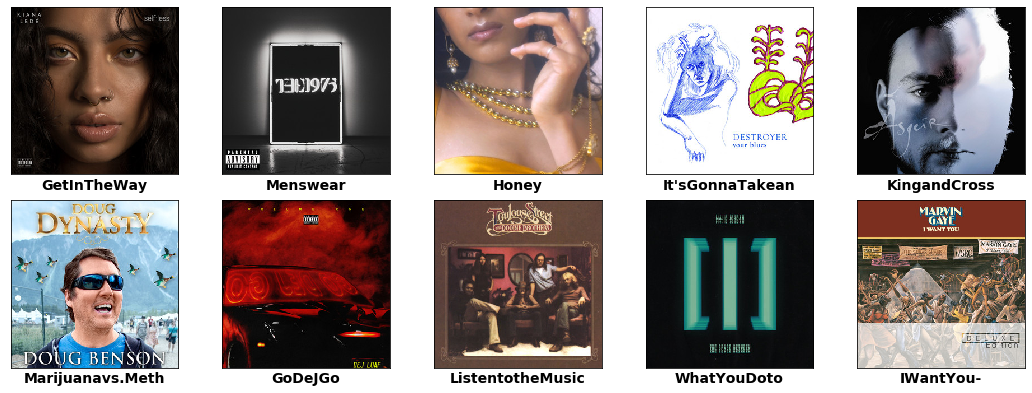

In [357]:
generating_cover_art(top10_for_playlist_input)

___Cover Arts for Top 10 Songs not present in User Saved Songs:___

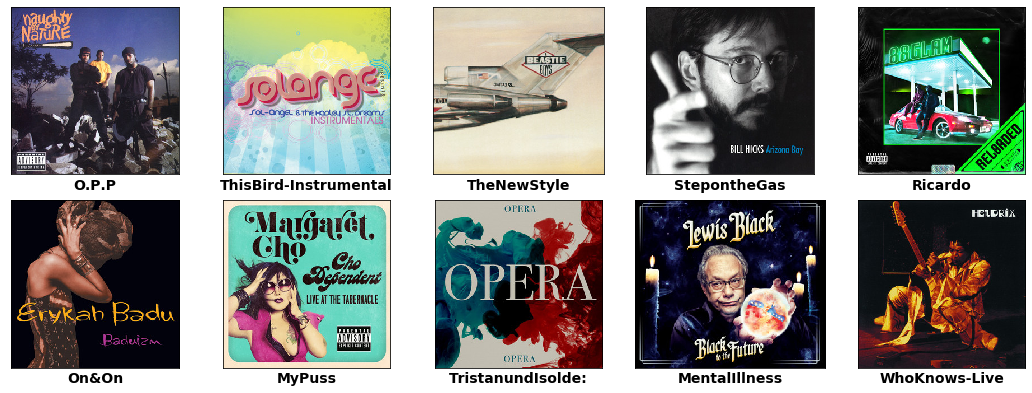

In [358]:
generating_cover_art(top10_for_savedsongs_input)